#  Prepare a neural network with appropriate activation functions, so that it has the same architecture as shown in the following Figure-1.

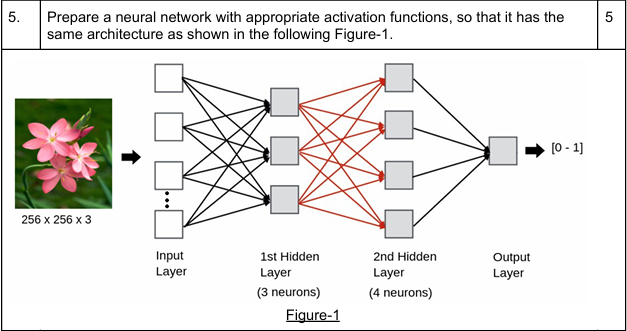

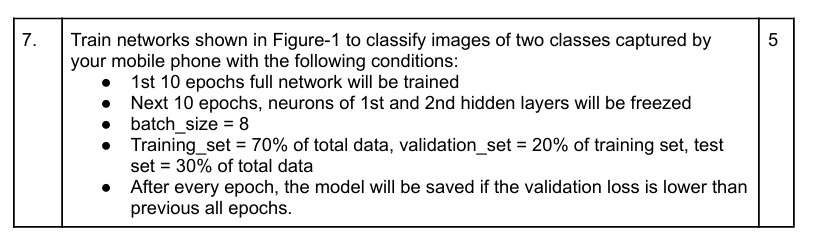

In [28]:
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv

### Parameters

In [29]:
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 8
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 10
TOTAL_EPOCHS = EPOCHS_PHASE1 + EPOCHS_PHASE2

### Load and Preprocess Dataset

Class label mapping: {'Glass': 0, 'Plate': 1}


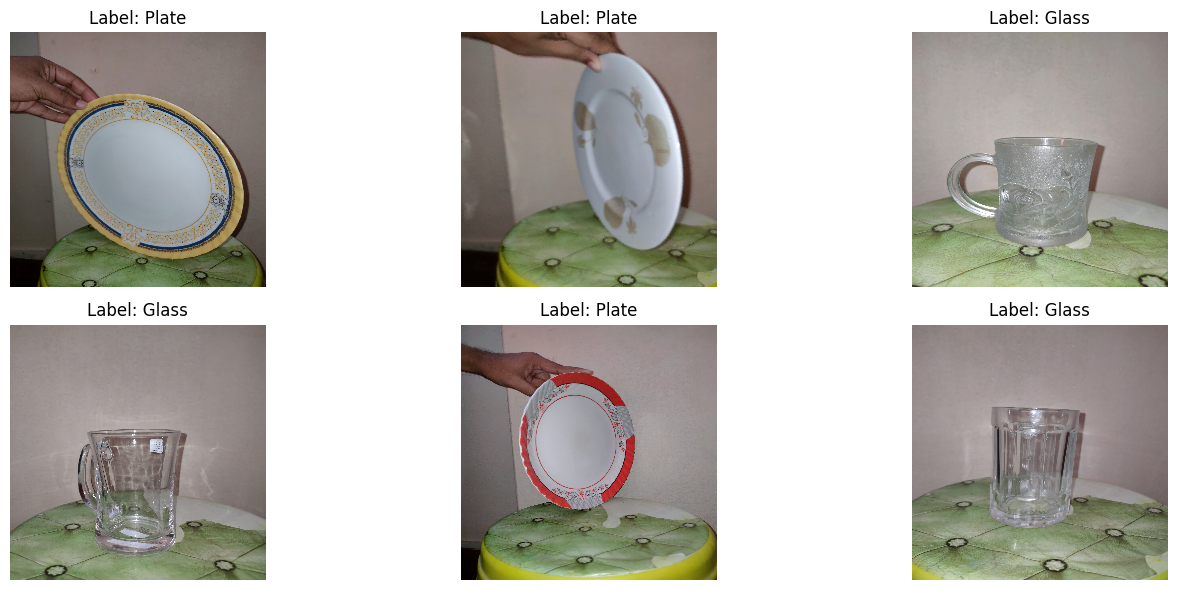

Training set: 35
Validation set: 9
Test set: 19


In [30]:
# Dataset directory
DATA_DIR = './GlassPlateDataset'


# LOAD + RESIZE + NORMALIZE IMAGES (DIRECTLY IN MEMORY)

def load_and_preprocess_images_cv2(input_dir, target_size=(256, 256)):
    images = []
    labels = []
    class_names = sorted(os.listdir(input_dir))  # Sorted for consistent labels
    class_to_label = {class_name: i for i, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = cv.imread(img_path)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, target_size)
                img_array = img / 255.0  # Normalize to [0,1]
                images.append(img_array)
                labels.append(class_to_label[class_name])
            except Exception as e:
                print(f"Skipping {img_path}: {e}")

    return np.array(images), np.array(labels), class_to_label

images, labels, class_to_label = load_and_preprocess_images_cv2(DATA_DIR)

# DISPLAY SAMPLE IMAGES
def show_sample_images(images, labels, class_to_label, num_samples=6):
    class_names = {v: k for k, v in class_to_label.items()}  # reverse dict
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(images[idx])
        label_name = class_names[labels[idx]]
        plt.title(f"Label: {label_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Class label mapping:", class_to_label)
show_sample_images(images, labels, class_to_label)

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.30, stratify=labels, random_state=42)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

print(f"Training set: {len(X_train_final)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

# CREATE TENSORFLOW DATASETS
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final)).batch(BATCH_SIZE).shuffle(buffer_size=100)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


### MODEL ARCHITECTURE (Input → 3 neurons → 4 neurons → Output)

In [31]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3), name = 'Input_Layer')

x = Flatten()(inputs)
x = Dense(3, activation = 'relu', name = 'Hidden_Layer_1')(x)
x = Dense(4, activation = 'relu', name = 'Hidden_Layer_2')(x)

outputs = Dense(1, activation = 'sigmoid', name = 'Output_Layer')(x)

model = models.Model(inputs, outputs, name = 'My_Model')

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

# CALLBACK FOR SAVING BEST MODEL
checkpoint = callbacks.ModelCheckpoint(
    'best_model_nn_f1.h5', monitor='val_accuracy', save_best_only=True, mode='min'
)

Model: "My_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_1 (Dense)          │ (None, 3)              │       589,827 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 4)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,848 (2.25 MB)

 Trainable params: 589,848 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

### TRAIN FIRST 10 EPOCHS (Full model trainable)

In [32]:
history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS_PHASE1,
    callbacks=[checkpoint]
)

Epoch 1/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 606ms/step - accuracy: 0.3333 - loss: 0.7090

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4367 - loss: 0.9463 - val_accuracy: 0.5556 - val_loss: 0.6929
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4689 - loss: 0.6932 - val_accuracy: 0.5556 - val_loss: 0.6927
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5184 - loss: 0.6930 - val_accuracy: 0.5556 - val_loss: 0.6926
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5287 - loss: 0.6929 - val_accuracy: 0.5556 - val_loss: 0.6925
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5627 - loss: 0.6924 - val_accuracy: 0.5556 - val_loss: 0.6923
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5584 - loss: 0.6923 - val_accuracy: 0.5556 - val_loss: 0.6922
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4943 - loss: 0.6933 - val_accuracy: 0.5556 - val_loss: 0.6922
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5221 - loss: 0.6928 - val_accuracy: 0.5556 - val_loss: 0.6921
Epoch 9/10
5/5 ━━

### TRAIN NEXT 10 EPOCHS (Hidden layers frozen)

In [33]:
# FREEZE hidden1 and hidden2
model.get_layer('Hidden_Layer_1').trainable = False
model.get_layer('Hidden_Layer_2').trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# TRAIN NEXT 10 EPOCHS (Hidden layers frozen)
history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=TOTAL_EPOCHS,
    initial_epoch=EPOCHS_PHASE1,
    callbacks=[checkpoint]
)

Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5564 - loss: 0.6919 - val_accuracy: 0.5556 - val_loss: 0.6917
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5625 - loss: 0.6916 - val_accuracy: 0.5556 - val_loss: 0.6917
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4870 - loss: 0.6936 - val_accuracy: 0.5556 - val_loss: 0.6916
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5314 - loss: 0.6923 - val_accuracy: 0.5556 - val_loss: 0.6916
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5522 - loss: 0.6917 - val_accuracy: 0.5556 - val_loss: 0.6915
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4914 - loss: 0.6936 - val_accuracy: 0.5556 - val_loss: 0.6914
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4839 - loss: 0.6938 - val_accuracy: 0.5556 - val_loss: 0.6914
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5287 - loss: 0.6923 - val_accuracy: 0.5556 - val_loss: 0.6913

### EVALUATE ON TEST SET

In [34]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n✅ Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4975 - loss: 0.6934 



✅ Final Test Accuracy: 0.5263, Test Loss: 0.6923
